### Estimating thermodynamic sea-ice growth during the breakup event 

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 27 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [2]:
%matplotlib notebook
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import struct
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import datetime as dt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import pynextsim.openers as pnops
import mod_netcdf_utils as mnu
import pynextsim.gridding as png
from pynextsim.netcdf_list import NetcdfList
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import matplotlib.pyplot as plt
from pynextsim.nextsim_bin import NextsimBin as nb
from pynextsim.projection_info import ProjectionInfo

import matplotlib.dates as mdates
import pandas as pd
import cmocean as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches


In [3]:
def make_figure(wi, hi, nrow,ncol):

    fig = plt.figure(figsize=(wi,hi))
    #plt.subplots_adjust(hspace=5, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 

def weighted_volume_growth(fraction_mask, var, mask):
    
    # total growth in terms of volume (m3)
    dx=5*1000 # 5 km res
    dy=dx
    cellarea = dx*dy
    
    leadfraction_area = cellarea*fraction_mask # area of the cell which is lead or pack ice
    
    vol = leadfraction_area*var # ice growth in each cell multiplied by area (m3)
    
    # apply mask
    vol = vol.where(mask==1)
    vol_weighted = vol.sum(axis=(1,2)) # m3
    #vol_weighted = vol.sum(axis=(1,2))/leadfraction_area.sum(axis=(1,2)) # divide by total area of lead or pack ice
    
    return vol_weighted

In [4]:
# load data

rootdir = '/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/'

expts = ["expt_01_wrf10/outputs-v11/", "expt_02_wrf20/outputs/","expt_03_wrf40/outputs/","expt_04_wrf80/outputs/", "expt_01_wrf10-nodyn/outputs/"]
expts_names = ["wrf10", "wrf20","wrf40","wrf80", 'no_motion']

#expts = ["expt_01_wrf10/outputs-v11/", "expt_05_wrf10-sitx0.5/outputs/","expt_06_wrf10-sitx1.5/outputs/", 
#         "expt_07_wrf10-sitx2.0/outputs/"]
#expts_names = ["std", "x0.5", "x1.5", "x2.0"]

files = [os.path.join(rootdir, f, 'Moorings.nc') for f in expts]

k=0 # which expt?
ds = xr.open_dataset(files[k])

time = ds['time'].time.values.astype('datetime64[ms]').astype('O')

days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting 

In [5]:
# get the growth rate pr. unit output freq (i.e. 3 hrs)

# the units of the growth rate for (del_hi, del_hi_thin and newice) is in [m/day]. 
# Because the moorings are written at 3 hourly intervals we need to divide del_hi, del_hi_thin and newice with the output freq. 
# This will give us the growth/melt during a 3 hr window.  

# get freq
output_timestep=.125 # 3hourly
output_freq = 1/output_timestep
print("output frequency ", output_freq)

# apply to growth rate variables
varlist = ['newice', 'del_hi_thin', 'del_hi']
for var in varlist:
    print(var)
    ds[var] = ds[var]/output_freq

# convert to units volume
thick_frac = ds['sic'] - ds['sic_thin']# Concentration of old ice
thin_frac = ds['sic_thin']# Concentration of thin ice

newice = ds['newice']
del_hi_thin = ds['del_hi_thin']*thin_frac 
del_hi = ds['del_hi']*thick_frac 

# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410


output frequency  8.0
newice
del_hi_thin
del_hi


In [6]:
# create mask based on the slices

mask_ocean = 1 * np.ones((ds.dims['y'], ds.dims['x'])) * np.isfinite(ds.sic.isel(time=0))  
mask_land = np.zeros((ds.dims['y'], ds.dims['x'])) * np.isnan(ds.sic.isel(time=0))  
mask_array = mask_ocean + mask_land

mask = mask_array.where((mask_array.x >= x0) & (mask_array.x <= x1) 
                         & (mask_array.y >= y0) & (mask_array.y <= y1))


# total area in Beaufort Sea
cella = 25000000 # 5km
ncells = np.count_nonzero(~np.isnan(mask.where(mask==1))) # only account for ocean cells
area = ncells*cella
print("Total area in Beaufort Sea:", area*1e-6, "km2")


Total area in Beaufort Sea: 1355475.0 km2


# Average volume growth in the Beaufort Sea for different ice types

<IPython.core.display.Javascript object>


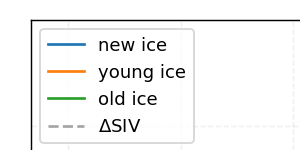

saving... /cluster/home/rheinlender/projects/aoi_case_study/breakup-paper/figs/volume_growth_beaufort_wrf10.png


In [9]:
def calc_vol_growth(var, mask, cella):
    
    # apply mask
    masked_var = var.where(mask==1)
    
    delV = masked_var*cella # in m3/3hrs
    
    delVsum = delV.sum(dim=("x", "y"), skipna=True) # m3/3hrs total volume growth 
    
    return  delVsum

# estimate ice volume growth
dvol_newice  = calc_vol_growth(newice, mask, cella) 
dvol_youngice = calc_vol_growth(del_hi_thin, mask, cella) 
dvol_oldice = calc_vol_growth(del_hi, mask, cella)     

# total ice volume growth (cumulative sum)
dvol_newice_tot  = dvol_newice.cumsum(axis=0) # in m3
dvol_youngice_tot = dvol_youngice.cumsum(axis=0) 
dvol_oldice_tot = dvol_oldice.cumsum(axis=0) 

## calculate total ice volume in the Beaufort Sea from thickness field
siv_beaufort = ds['sit'].where(mask==1)*cella # in m3
siv_total_beaufort = siv_beaufort.sum(dim=("x", "y"))  

# calculate anomaly with respect to start of simulation
siv_anom_beaufort = siv_total_beaufort - siv_total_beaufort[0]  

# cumulative ice growth in leads
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(4,2.5))
l1 = ax.plot(time, dvol_newice_tot*1e-9, label='new ice')
l2 = ax.plot(time, dvol_youngice_tot*1e-9, label='young ice')
l3 = ax.plot(time, dvol_oldice_tot*1e-9, label='old ice')
l4 = ax.plot(time, siv_anom_beaufort*1e-9, label='$\Delta$SIV', color = 'grey', alpha=0.7, linestyle='--') 
#ax.set_title('Total volume growth')
ax.set_ylabel('Volume growth ($\mathrm{km^3}$)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

#ax.label_outer()
ax.grid(linestyle='--', alpha=0.2)
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
plt.xticks(rotation=45) # rotate xlabels
plt.legend()

fig.subplots_adjust(bottom=0.26, top=0.98, left=0.03, right=0.85, wspace=0.01, hspace=0.01)
plt.show()

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'volume_growth_beaufort',expts_names[k], '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')


# Average thickness growth in the Beaufort Sea

The average increase in thickness due to thermodynamic growth in the Beaufort Sea is estimated by dividing the total volume growth by the total area of the Beaufort Sea.  

<IPython.core.display.Javascript object>


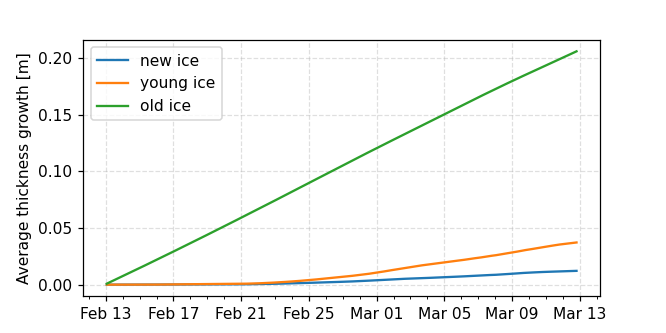

average thickness growth in the Beaufort Sea: 0.2554262933542411


In [154]:
def thickness_growthrate(var, mask, cella):
    
    # apply mask
    masked_var = var.where(mask==1)
    
    delV = masked_var*cella # in m3/3hrs
    
    delVsum = delV.sum(dim=("x", "y"), skipna=True) # m3/3hrs total volume growth 
    
    delH = delVsum/area
    
    return  delH

delH_newice = thickness_growthrate(newice, mask, cella) 
delH_youngice = thickness_growthrate(del_hi_thin, mask, cella) 
delH_oldice = thickness_growthrate(del_hi, mask, cella) 

delH_tot = delH_newice+delH_youngice+delH_oldice

# plot average (cumulative) growth
fig, ax = plt.subplots(1,1, figsize=(6,3))
l11 = ax.plot(time, delH_tot.cumsum(axis=0))
ax.set_ylabel('Average thickness growth [m]')
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.grid(linestyle='--', alpha=0.4)

print("Average thickness growth in the Beaufort Sea:", delH_tot.cumsum(axis=0)[-1].values, " m")


# Average thickness growth weighted by respective ice type area

In order to estimate how much ice is grown within leads and packice seperately, we weight the growth by the respective area representing leads or packice, i.e. from the total fraction of open-water + thin ice (=leads) and the fraction covered by old ice (packice). 

In that case the average growth esitmates are much higher for newice (~4m) and young-ice (2m) because the it only occurs in a few gridcells (small area). Although the total growth in packice is greater, the average growth is smaller (~20cm) because it occurs over a larger area. 

In [1]:
# calculate the total weighted growth rate in leads and pack ice

def thickness_growthrate_weighted(fraction_mask, var, mask):
    
    # apply mask for Beaufort Sea
    masked_var = var.where(mask==1)
    
    delV = masked_var*cella # Volume growth (in m3/3hrs)
    
    # total volume growth in Beaufort Sea
    delVsum = delV.sum(dim=("x", "y"), skipna=True) # m3/3hrs 
    
    area_mask = fraction_mask*cella
    
    # total area which is open-water, young ice and old ice, respectively 
    area_mask_sum = area_mask.where(mask==1).sum(dim=('x', 'y'))   
    
    # average growth in meters weighted by the newice-, youngice- and oldice area
    delH_weighted = delVsum/area_mask_sum
        
    return delH_weighted

# fraction of openwater and thin ice 
leadfraction = 1 - ds['sic'] + ds['sic_thin']

# get the fraction of pack ice (1 - leadfraction)
packfraction = 1 - leadfraction 

delH_newice_wt  = thickness_growthrate_weighted((1 - ds['sic']), newice, mask) 
delH_youngice_wt = thickness_growthrate_weighted(ds['sic_thin'], del_hi_thin, mask) 
delH_oldice_wt = thickness_growthrate_weighted(packfraction, del_hi, mask)     
     
fig, ax = plt.subplots(2,1, figsize=(5,4))
ax[0].plot(time, delH_newice_wt.cumsum(axis=0),  label='new ice')
ax[0].plot(time, delH_youngice_wt.cumsum(axis=0),label='young ice')
ax[0].plot(time, delH_oldice_wt.cumsum(axis=0) , label='old ice')
ax[0].set_ylabel('Total ice growth [m]')

ax[1].plot(time, delH_newice_wt*1e2,  label='new ice')  # in cm/3hr
ax[1].plot(time, delH_youngice_wt*1e2, label='young ice')
ax[1].plot(time, delH_oldice_wt*1e2, label='old ice')
ax[1].set_ylabel(r'Growth rate [cm $\mathrm{3hr^{-1}}$]')

ax[0].legend()

for axs in ax:
    axs.label_outer()
    axs.grid(linestyle='--', alpha=0.4)
    axs.xaxis.set_major_formatter(dtFmt)
    axs.xaxis.set_minor_locator(days)

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'thickness_growth_wt_beaufort',expts_names[k], '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')
    
# Create dataframe with the average growth in open-water, youngice and oldice
df = pd.DataFrame(columns=['Expt', 
                           'Growth in open-water (m)', 
                           'Growth in young-ice (m)', 
                           'Growth in old-ice (m)'])

data0 = delH_newice_wt.cumsum(axis=0)[-1]
data1 = delH_youngice_wt.cumsum(axis=0)[-1]
data2 = delH_oldice_wt.cumsum(axis=0)[-1]

# APPEND TO DATAFRAME
df.loc[k] = [expts_names[k], 
             data0.round(decimals=1).values, 
             data1.round(decimals=1).values, 
             data2.round(decimals=1).values, 
                 ]
df


NameError: name 'ds' is not defined

# Map of the Beaufort Sea ice thickness

In [105]:
# plotting
def prepare_grid(ds):
    
    # Get x-y grid from model
    lons = ds.longitude[:]
    lats = ds.latitude[:]
    x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
    x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
    y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
    ex_lim=1
    x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
    y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

    grid = dict(
        extent=extent,
        proj=proj,
        x_extent=x_extent,
        y_extent=y_extent,
        )

    return grid

def plot_nextsim(ax, grid, array, clevs, cmap, add_colorbar=True, **cbargs):
    
    cs = ax.contourf(array, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']],
             levels=clevs, cmap=cmap, **cbargs)

    # add contour lines
    cl = ax.contour(array, extent=[*grid['x_extent'], *grid['y_extent']], levels=clevs,  
                                   colors='k', linestyles='-',linewidths=0.3)
         
    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, color="darkgrey")
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")
    ax.set_extent([-100, -50, 67, 87], ccrs.PlateCarree(central_longitude=300))

    # add colorbar 
    if add_colorbar:
        cax = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)

        out = plt.colorbar(cs, cax=cax, **cbargs)

def add_box(ax,**kwargs):
    # Adds a box in axes coordinates outlining the Beaufort Sea
    
    nextsim_proj = ProjectionInfo() # default nextsim projection

    # subset region: Beaufort Sea
    x0=0; x1=260
    y0=150; y1=410

    # make Beaufort Box
    nlon = ds.longitude.values
    nlat = ds.latitude.values
    lon_corners = (nlon[y1,x0], nlon[y0,x0], nlon[y0,x1],  nlon[y1,x1]) 
    lat_corners = (nlat[y1,x0], nlat[y0,x0], nlat[y0,x1], nlat[y1,x1]) 

    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners

    kw = {'ec':'k', 'ls':'-', 'fill':'True', 'lw':1, 'zorder':10,'facecolor': 'white', 'alpha':0.3}
    poly = mpatches.Polygon(poly_corners, closed=True, transform=ccrs.Geodetic(), **kw)

    ax.add_patch(poly)  
    

def inset_BeaufortBox(ax):
    
    # Projection stuff
    extent = [-110, 200, 67, 90]
    proj = ProjectionInfo() # default nextsim projection
    grid = prepare_grid(ds)

    # get colormap from tab20c
    col=plt.cm.Blues([50,100, 150, 200])
    newcmp = ListedColormap(col)

    # distinct thickness levels
    clevs = [0,1 ,1.6, 4]

    cbargs = {"label": "Thickness (m)"}

    sit = ds['sit'].sel(time="2013-02-13").mean(axis=0)

    ## Make the plot  
    #fig, ax = plt.subplots(1,1, figsize=(10,4), constrained_layout=True,
    #                       subplot_kw={'projection': grid['proj'].crs, 'extent': grid['extent']})

    plot_nextsim(ax, grid, sit, clevs, newcmp, add_colorbar=False, **cbargs)

    # draw Beaufort box
    add_box(ax)

    # add text
    kw = dict(verticalalignment='bottom', horizontalalignment='center', 
                      transform=ax.transAxes, color='k', fontsize=9, zorder=10,
                      bbox={'facecolor':'None', 'edgecolor':'None', 'alpha':0.7, 'pad':0})
    ax.text(0.58, 0.5, '>1.6',**kw)
    ax.text(0.25, 0.4, '1$-$1.6 ',**kw)
    ax.text(0.33, 0.8, '<1',**kw)


# Histograms of sea-ice thickness before and after breakup 

<IPython.core.display.Javascript object>


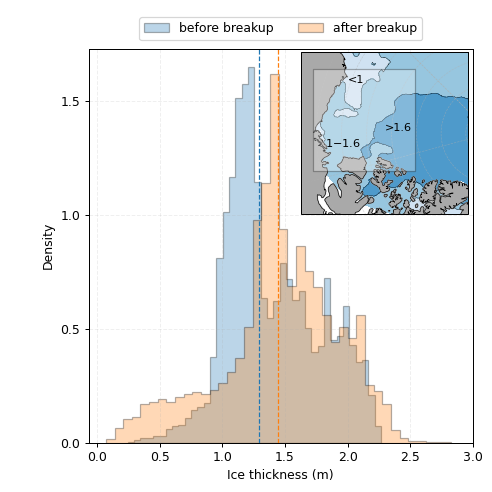

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


saving... /cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/histSIT_beaufort_wrf10.png
mean thickness on 2013-02-16 : 1.3963089
mean thickness on 2013-03-12 : 1.4502151
median thickness on 2013-02-16 : 1.2906121
median thickness on 2013-03-12 : 1.4485677


In [108]:
plt.close('all')

# calculate thickness in Beaufort Sea 
sitBS = ds['sit'].sel(x=slice(x0,x1), y=slice(y0,y1))

# pick dates to plot
t1 = '2013-02-16' # start of simulation
t2 = '2013-03-12' # end of simulation

print("mean thickness on", t1, ":", sitBS.sel(time=t1).mean().values)
print("mean thickness on", t2, ":", sitBS.sel(time=t2).mean().values)
print("median thickness on", t1, ":", sitBS.sel(time=t1).median().values)
print("median thickness on", t2, ":", sitBS.sel(time=t2).median().values)

legstr = ['before breakup', 'after breakup']

kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40, ec="k")

#fig, ax = plt.subplots(1,1, figsize=(3,4)) #old
fig, ax = plt.subplots(1,1, figsize=(5.5,5.5))
hist1 = sitBS.sel(time=t1).plot.hist(ax=ax, **kwargs) # before break-up
hist2 = sitBS.sel(time=t2).plot.hist(ax=ax, **kwargs) # after break-up
ax.set_ylabel('Density')
ax.set_xlabel('Ice thickness (m)')
ax.set_title("")
ax.grid(linestyle='--', alpha=0.2)

# legend
ax.legend(legstr,loc='upper center', ncol=2, 
          bbox_to_anchor=(0.5, 1.08),  borderaxespad=0.
         )

# add median 
ax.axvline(sitBS.sel(time=t1).median(), color='C0', linestyle='dashed', linewidth=1)
ax.axvline(sitBS.sel(time=t2).median(), color='C1', linestyle='dashed', linewidth=1)
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_xticks([0, 0.5, 1, 1.5, 2.0, 2.5, 3.0])
#ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
#ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())


# inset axis
ax_inset =inset_axes(ax, height="41%", width="44%", 
                     loc='upper right', borderpad=0.3,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(map_projection=grid['proj'].crs)) # center
inset_BeaufortBox(ax_inset)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.18, right=0.96, wspace=0.01, hspace=0.01)
plt.show()


# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'histSIT_beaufort',expts_names[k], '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# Ice volume growth estimates for all expts

In [159]:

rootdir = '/cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/'
expts = ["expt_01_wrf10/outputs-v11/", 
         "expt_02_wrf20/outputs/",
         "expt_03_wrf40/outputs/",
         "expt_04_wrf80/outputs/", 
         "expt_05_wrf10-sitx0.5/outputs/",
         "expt_06_wrf10-sitx1.5/outputs/", 
         "expt_07_wrf10-sitx2.0/outputs/",
         "expt_01_wrf10-nodyn/outputs/",
        ]

labelstr = ["wrf10", "wrf20","wrf40","wrf80", "SIT*0.5", "SIT*1.5", "SIT*2.0", "no_motion"]

files = [os.path.join(rootdir, f, 'Moorings.nc') for f in expts]

ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])
ds2 = xr.open_dataset(files[2])
ds3 = xr.open_dataset(files[3])
ds4 = xr.open_dataset(files[4])
ds5 = xr.open_dataset(files[5])
ds6 = xr.open_dataset(files[6])
ds7 = xr.open_dataset(files[7])

dslist = [ds0, ds1, ds2, ds3, ds4, ds5, ds6, ds7]

# create dataframe
df = pd.DataFrame(columns=['name', 'growth in leads (km3)', 'growth in packice (km3)', 'leads+pack (km3)', 'dSIV (km3)'])

# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410

varlist = ['newice', 'del_hi_thin', 'del_hi']
for i, ds in enumerate(dslist):
    print("loading", files[i])
    
    leadfraction = 1 - ds['sic'] + ds['sic_thin']
    packfraction = 1 - leadfraction     # get the fraction of pack ice (1 - leadfraction)

    mask_ocean = 1 * np.ones((ds.dims['y'], ds.dims['x'])) * np.isfinite(ds.sic.isel(time=0))  
    mask_land = np.zeros((ds.dims['y'], ds.dims['x'])) * np.isnan(ds.sic.isel(time=0))  
    mask_array = mask_ocean + mask_land
    mask = mask_array.where((mask_array.x >= x0) & (mask_array.x <= x1) 
                             & (mask_array.y >= y0) & (mask_array.y <= y1))

    for var in varlist:
        ds[var] = ds[var]/output_freq
    
    # convert to units volume
    newice = ds['newice']
    del_hi_thin = ds['del_hi_thin']*ds['sic_thin']
    del_hi = ds['del_hi']*(ds['sic'] - ds['sic_thin'])
    
    # calculate ice volume growth
    dvol_newice  = calc_vol_growth(newice, mask, cella) 
    dvol_youngice = calc_vol_growth(del_hi_thin, mask, cella) 
    dvol_oldice = calc_vol_growth(del_hi, mask, cella)     

    # total ice volume growth (cumulative sum)
    dvol_newice_tot  = dvol_newice.cumsum(axis=0)*1e-9 # in km3
    dvol_youngice_tot = dvol_youngice.cumsum(axis=0)*1e-9 
    dvol_oldice_tot = dvol_oldice.cumsum(axis=0)*1e-9  
    
    # Total ice volume 
    sivBS = ds['sit'].where(mask==1)*cella # in m3
    sivBS_total = sivBS.sum(dim=("x", "y"))*1e-9 
    dsivBS = sivBS_total.isel(time=[-1]).mean() - sivBS_total.isel(time=0).mean()
    
    # Calculate the total change in volume in leads and pack-ice combined
    dvol_lead = dvol_newice_tot + dvol_youngice_tot
    dvol_pack = dvol_oldice_tot
    dvol_total = dvol_lead + dvol_pack 

    # APPEND TO DATAFRAME
    df.loc[i] = [labelstr[i], 
                 dvol_lead[-1].round(decimals=1).values, 
                 dvol_pack[-1].round(decimals=1).values,
                 dvol_total[-1].round(decimals=1).values, 
                 dsivBS.round(decimals=1).values]

df

loading /cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_01_wrf10/outputs-v11/Moorings.nc
loading /cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_02_wrf20/outputs/Moorings.nc
loading /cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_03_wrf40/outputs/Moorings.nc
loading /cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_04_wrf80/outputs/Moorings.nc
loading /cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_05_wrf10-sitx0.5/outputs/Moorings.nc
loading /cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_06_wrf10-sitx1.5/outputs/Moorings.nc
loading /cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_07_wrf10-sitx2.0/outputs/Moorings.nc
loading /cluster/work/users/rheinlender/breakup2013/wrf-exp/start_20130213_nudging/expt_01_wrf10-nodyn/outputs/Moorings.nc


,name,growth in leads (km3),growth in packice (km3),leads+pack (km3),dSIV (km3)
0,wrf10,67.0,279.2,346.2,112.9
1,wrf20,68.9,279.7,348.5,105.9
2,wrf40,74.6,284.0,358.5,91.7
3,wrf80,74.2,289.5,363.8,108.1
4,SIT*0.5,80.9,363.5,444.4,301.5
5,SIT*1.5,47.5,226.4,273.9,22.9
6,SIT*2.0,22.1,188.6,210.7,62.4
7,no_motion,0.0,277.3,277.3,276.2


In [22]:
# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410

# make Beaufort Box
nlon = ds.longitude.values
nlat = ds.latitude.values
lon_corners = (nlon[y1,x0], nlon[y0,x0], nlon[y0,x1],  nlon[y1,x1]) 
lat_corners = (nlat[y1,x0], nlat[y0,x0], nlat[y0,x1], nlat[y1,x1]) 
print(lat_corners)
print(lon_corners)

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners


(67.246994, 68.10054, 79.729576, 77.95747)
(-154.8929, -122.933556, -108.264465, -175.45337)


In [ ]:
df